## A1: Data Curation Assignment
## Jack Chen

### Step 1: Data Acquisition

In [168]:
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [81]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

legacy_start = '200712'
legacy_end = '201607'

pageviews_start = '201507'
pageviews_end = '202108'


In [82]:
# Legacy Pagecount API parameters for desktop and mobile
params_legacy_desktop = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                # for end use 1st day of month following final month of data
                 "end" : "2016080100"
                    }

params_legacy_mobile = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                # for end use 1st day of month following final month of data
                 "end" : "2016080100"
                    }

In [83]:
# Pageviews API parameters for desktop, mobile web and app
params_pageviews_desktop = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2021090100'
                        }

params_pageviews_mobile_web = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2021090100'
                        }

params_pageviews_mobile_app = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2021090100'
                        }

In [84]:
# Customize these with your own information
headers = {
    'User-Agent': 'https://github.com/jchen023',
    'From': 'jchen023@uw.edu'
}

In [85]:
def api_call(endpoint, parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    return response

In [86]:
legacy_desktop = api_call(endpoint_legacy, params_legacy_desktop)
legacy_mobile = api_call(endpoint_legacy, params_legacy_mobile)

In [87]:
pageview_desktop = api_call(endpoint_pageviews, params_pageviews_desktop)
pageview_mobile_web = api_call(endpoint_pageviews, params_pageviews_mobile_web)
pageview_mobile_app = api_call(endpoint_pageviews, params_pageviews_mobile_app)

In [88]:
with open('../data_raw/legacy-pagecount_desktop-site_200712-201607.json', 'w') as output:
    json.dump(legacy_desktop, output)

with open('../data_raw/legacy-pagecount_mobile-site_200712-201607.json', 'w') as output:
    json.dump(legacy_mobile, output)

In [89]:
with open('../data_raw/pageviews_desktop-site_201507-202108.json', 'w') as output:
    json.dump(pageview_desktop, output)

with open('../data_raw/pageviews_mobile-web_201507-202108.json', 'w') as output:
    json.dump(pageview_mobile_web, output)

with open('../data_raw/pageviews_mobile-app_201507-202108.json', 'w') as output:
    json.dump(pageview_mobile_app, output)

### Data Processing

In [125]:
pagecount_desktop_views = pd.DataFrame.from_dict(legacy_desktop['items']).rename(
    columns = {"timestamp": "time", "count": "pagecount_desktop_views"}).iloc[:, -2:]
pagecount_mobile_views = pd.DataFrame.from_dict(legacy_mobile['items']).rename(
    columns = {"timestamp": "time", "count": "pagecount_mobile_views"}).iloc[:, -2:]

pageview_desktop_views = pd.DataFrame.from_dict(pageview_desktop['items']).rename(
    columns = {"timestamp": "time", "views": "pageview_desktop_views"}).iloc[:, -2:]
pagecount_mobile_web_views = pd.DataFrame.from_dict(pageview_mobile_web['items']).rename(
    columns = {"timestamp": "time", "views": "pagecount_mobile_web_views"}).iloc[:, -2:]
pagecount_mobile_app_views = pd.DataFrame.from_dict(pageview_desktop['items']).rename(
    columns = {"timestamp": "time", "views": "pagecount_mobile_app_views"}).iloc[:, -2:]

pagecount_desktop_views["time"] = pagecount_desktop_views["time"].astype('|S80').str.decode('UTF-8')
pagecount_mobile_views["time"] = pagecount_mobile_views["time"].astype('|S80').str.decode('UTF-8')
pageview_desktop_views["time"] = pageview_desktop_views["time"].astype('|S80').str.decode('UTF-8')
pagecount_mobile_web_views["time"] = pagecount_mobile_web_views["time"].astype('|S80').str.decode('UTF-8')
pagecount_mobile_app_views["time"] = pagecount_mobile_app_views["time"].astype('|S80').str.decode('UTF-8')

In [156]:
# D
df = (pagecount_desktop_views.set_index("time")
      .merge(pagecount_mobile_views.set_index("time"), left_index=True, right_index=True, how='outer')
      .merge(pageview_desktop_views.set_index("time"), left_index=True, right_index=True, how='outer')
      .merge(pagecount_mobile_web_views.set_index("time"), left_index=True, right_index=True, how='outer')
      .merge(pagecount_mobile_app_views.set_index("time"), left_index=True, right_index=True, how='outer')
      .reset_index())
df['year'] = df.time.str[:4]
df['month'] = df.time.str[4:6]
df = df.fillna(0)
df['pagecount_all_views'] = df['pagecount_desktop_views'] + df['pagecount_mobile_views']
df['pageview_mobile_views'] = df['pagecount_mobile_web_views'] + df['pagecount_mobile_app_views']
df['pageview_all_views'] = df['pageview_mobile_views'] + df['pageview_desktop_views']
df.drop(columns=['time', 'pagecount_mobile_web_views', 'pagecount_mobile_app_views'], inplace=True)
df

,pagecount_desktop_views,pagecount_mobile_views,pageview_desktop_views,year,month,pagecount_all_views,pageview_mobile_views,pageview_all_views
0,2.998332e+09,0.0,0.000000e+00,2007,12,2.998332e+09,0.000000e+00,0.000000e+00
1,4.930903e+09,0.0,0.000000e+00,2008,01,4.930903e+09,0.000000e+00,0.000000e+00
2,4.818394e+09,0.0,0.000000e+00,2008,02,4.818394e+09,0.000000e+00,0.000000e+00
3,4.955406e+09,0.0,0.000000e+00,2008,03,4.955406e+09,0.000000e+00,0.000000e+00
4,5.159162e+09,0.0,0.000000e+00,2008,04,5.159162e+09,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
160,0.000000e+00,0.0,2.882714e+09,2021,04,0.000000e+00,7.479549e+09,1.036226e+10
161,0.000000e+00,0.0,2.824416e+09,2021,05,0.000000e+00,7.634511e+09,1.045893e+10
162,0.000000e+00,0.0,2.505971e+09,2021,06,0.000000e+00,6.939777e+09,9.445749e+09
163,0.000000e+00,0.0,2.765584e+09,2021,07,0.000000e+00,7.383033e+09,1.014862e+10


In [157]:
# Rearrange the columns orders to ideal output
df = df[['year', 'month', 'pagecount_all_views','pagecount_desktop_views', 
    'pagecount_mobile_views', 'pageview_all_views', 'pageview_desktop_views',  
       'pageview_mobile_views']]
df

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2.998332e+09,2.998332e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1,2008,01,4.930903e+09,4.930903e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2,2008,02,4.818394e+09,4.818394e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
3,2008,03,4.955406e+09,4.955406e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
4,2008,04,5.159162e+09,5.159162e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
160,2021,04,0.000000e+00,0.000000e+00,0.0,1.036226e+10,2.882714e+09,7.479549e+09
161,2021,05,0.000000e+00,0.000000e+00,0.0,1.045893e+10,2.824416e+09,7.634511e+09
162,2021,06,0.000000e+00,0.000000e+00,0.0,9.445749e+09,2.505971e+09,6.939777e+09
163,2021,07,0.000000e+00,0.000000e+00,0.0,1.014862e+10,2.765584e+09,7.383033e+09


In [158]:
df.to_csv("../data_clean/en-wikipedia_traffic_200712-202108.csv", index=False)

### Analysis

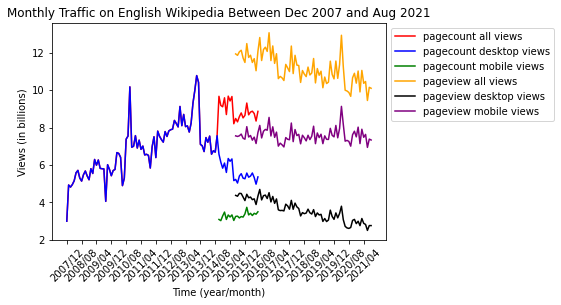

In [216]:
df = df.replace(0, np.nan)

plt.plot(df["year"] + "/" + df["month"], df.pagecount_all_views/1e9, c='r', label="pagecount all views")
plt.plot(df["year"] + "/" + df["month"], df.pagecount_desktop_views/1e9, c='blue', label="pagecount desktop views")
plt.plot(df["year"] + "/" + df["month"], df.pagecount_mobile_views/1e9, c='g', label="pagecount mobile views")
plt.plot(df["year"] + "/" + df["month"], df.pageview_all_views/1e9, c='orange', label="pageview all views")
plt.plot(df["year"] + "/" + df["month"], df.pageview_desktop_views/1e9, c='black', label="pageview desktop views")
plt.plot(df["year"] + "/" + df["month"], df.pageview_mobile_views/1e9, c='purple', label="pageview mobile views")

plt.xticks((df["year"] + "/" + df["month"])[::8],  rotation=45)
plt.ylabel("Views (in billions)")
plt.xlabel("Time (year/month)")
plt.title("Monthly Traffic on English Wikipedia Between Dec 2007 and Aug 2021")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
# plt.show()
plt.savefig('wiki_traffic.png',bbox_inches='tight')